# k1lib.mo module

This module is quite dope. It essentially allows you to construct, explore and simulate molecules (hence the "mo") quite easily. I suggest opening the official docs in another tab for reference. Let's get started.

In [1]:
from k1lib.imports import *

## Making molecules

So the basis for everything is the `Atom` class. There are several builtin substances:

In [2]:
mo.substances()[:10]

['H', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Na', 'Mg']

And there are some complicated substances too:

In [3]:
mo.substances()[-6:]

['glucose', 'cyclohexane', 'benzene', 'adenine', 'ribose', 'adenosine']

You can create a new substance really easily:

In [4]:
c = mo.C; c

<Atom C (6), 0 bonds, 4/8 valence electrons, 2 electron clouds, 0 free (radical) electrons>

That's it. Remember that each time you're accessing the substance, it'll create a new `Atom` entirely:

In [5]:
c == mo.C # different objects each time you request one!

False

For complex substances, it will still return a single `Atom`, not some other weird data structures:

In [6]:
mo.benzene

<Atom C (6), 4 bonds, 8/8 valence electrons, 0 electron clouds, 0 free (radical) electrons>

Let's see methane:

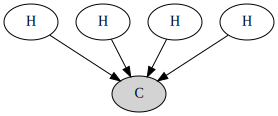

In [7]:
mo.CH4.show()

The highlighted circle is the current `Atom` we're showing the molecule from, and the arrows indicate the backbone's direction. To form a bond, you can do something like this:

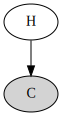

In [8]:
mo.C(mo.H).show()

Forming new bonds is sort of "safe". This means you don't have to pay too much attention to detail and it will still work. Let's bond a lone C to methane:

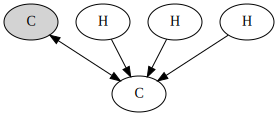

In [9]:
mo.C(mo.CH4).show()

As you can see, the methane automatically disconnects 1 Hydrogen, to make place for our bond. This means you can create complex molecules effortlessly. Here's ethanol:

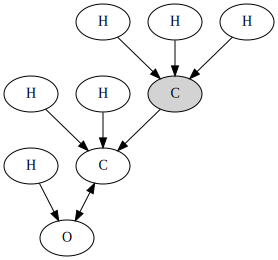

In [10]:
ethanol = mo.CH4(mo.H2O).bond(mo.CH4); ethanol.show()

`a.bond(b)` is really the same as `a(b)`, but `a.bond(b)` will return `b`, and `a(b)` will return `a` instead. There are several "convenience" methods to create molecules, like `mo.alkane()` and `mo.alcohol()`:

In [11]:
ethanol.empirical(), mo.alcohol(2).empirical()

('C2H6O', 'C2H6O')

You can also traverse the molecule quite easily:

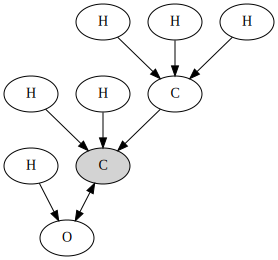

In [12]:
ethanol.next().show()

So when you call `.next()`, it will return the next molecule, which is indicated by the arrows. Meaning, if you call `.next()` on the oxygen, it will return the alpha Carbon, instead of the Hydrogen:

In [13]:
oxygen = ethanol.next().next(); oxygen

<Atom O (8), 2 bonds, 8/8 valence electrons, 2 electron clouds, 0 free (radical) electrons>

In [14]:
oxygen.next()

<Atom C (6), 4 bonds, 8/8 valence electrons, 0 electron clouds, 0 free (radical) electrons>

If you really wish to get the Hydrogen, you can do something like this:

In [15]:
oxygen.next(1)

<Atom H (1), 1 bonds, 2/2 valence electrons, 0 electron clouds, 0 free (radical) electrons>

Let's create tert-butanol:

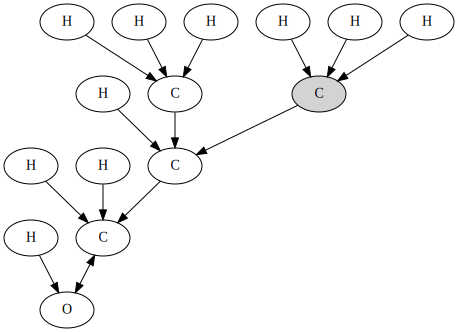

In [16]:
c = mo.CH4; c.bond(mo.CH4(mo.CH3OH)).bond(mo.CH4); c.show()

This all looks fine, however, notice the center carbon points to the CH3OH group instead. This might not be desirable, as you may want to navigate (using `.next()`) through the main propane chain. So you can do something slightly different:

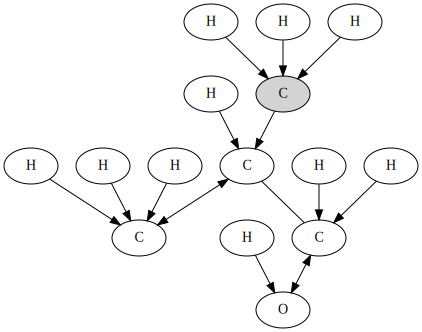

In [17]:
c = mo.CH4; c.bond(mo.CH4(mo.CH3OH)).main(mo.CH4); c.show()

Now, all the arrows are pointing correctly, so you can think of this molecule as "propane, with methanol attached at 2nd carbon", instead of "propanol, with methane attached at 2nd carbon".

There's also this really dope way to get molecules, and that is by just parsing it:

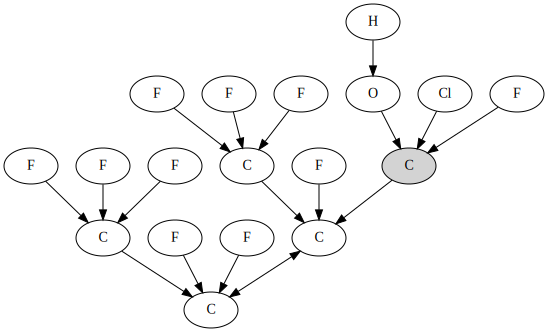

In [18]:
mo.parse("perfluoro-2,3-dimethyl-1-chloropropanol").show()

Experts among you might notice that "perfluoro-2,3-dimethyl-1-chloropropanol" doesn't exactly comply with IUPAC rules, so the good news is that the parser is quite lenient about this.

My parser usually can handle lots of substances, but not all of them. If there's a list of molecules that you'd wish to "just work", you can send me an email at 157239q@gmail.com. But tbh, shouldn't be that hard to construct any molecule that you want.

## Simulation

Now that you know how to construct molecules, let's talk about how you can simulate and view them. You need to first construct a `System`:

In [19]:
s = ethanol.system(); s

If you were to plot it right away, it looks terrible (graph in picometers btw):

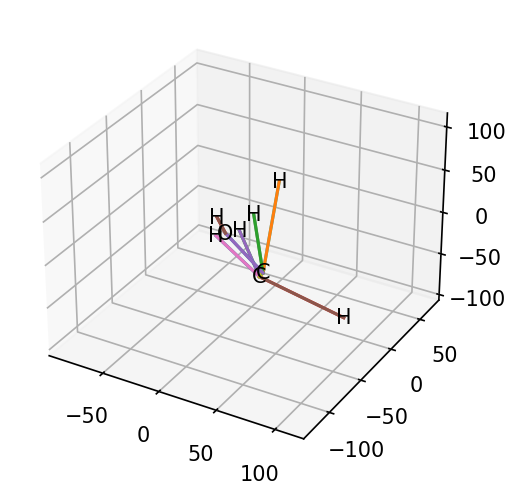

In [20]:
#%matplotlib widget # uncomment this in a notebook cell, if you want to pan around and look at the molecule in 3d
s.plot();

This is because the atom's position are randomly initialized. So you need to do a short simulation first:

In [21]:
xs = s.simulate()

Let's plot it:

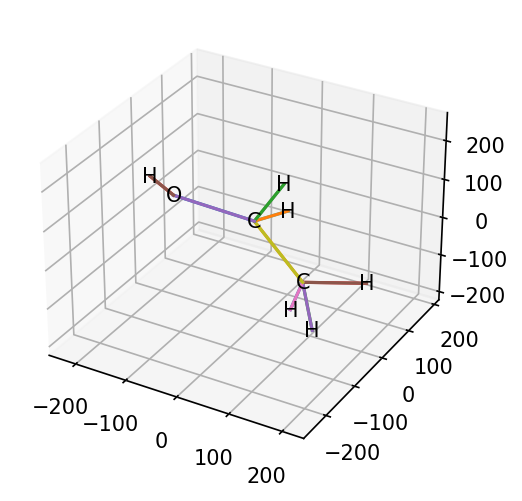

In [22]:
s.plot();

It looks wonderful now. `.simulate()` method returns a list of locations:

In [23]:
type(xs), type(xs[0]), xs[0].shape

(list, torch.Tensor, torch.Size([11, 3]))

This is quite useful if you want to see an animation of it:

In [24]:
s.animate(xs)

### Simulation speed analysis

How big of a molecule can the simulator handle? Let's try adenosine, a relatively complex molecule:

In [25]:
%%time
mo.adenosine.system().simulate(1000); mo.adenosine.empirical()

CPU times: user 260 ms, sys: 3.79 ms, total: 264 ms
Wall time: 263 ms


'C10H13O5N5'

So, 33-atom molecule, 1000 timesteps should take 250ms. Cool thing is, because the simulator is based on PyTorch, and if you have a GPU, then it can use that too:

In [26]:
torch.randn(2, 3).cuda(); # just to warm up stuff, so that our time measurements are accurate

In [27]:
%%time
mo.adenosine.system().simulate(1000, cuda=True); pass

CPU times: user 309 ms, sys: 58 µs, total: 309 ms
Wall time: 308 ms


Relatively same speeds. For a small molecule like adenosine, the performance gains isn't worth the overhead of using the GPU. Let's try attaching a bunch of adenosines together:

In [28]:
def ad(): return mo.adenosine.next() # do this cause main atom is the ribose's oxygen, not one of the carbons
c1, c2, c3, c4 = mo.alkane(4).nexts(4)
c1(ad())(ad())(ad())
c2(ad())(ad())
c3(ad())(ad())
c4(ad())(ad())(ad())
c1.empirical()

'C104H120O50N50'

324-atom molecule, pretty big. This is about 15 amino acid residues btw.

In [29]:
%%time
c1.system().simulate(1000); pass

CPU times: user 20.7 s, sys: 112 ms, total: 20.9 s
Wall time: 2.61 s


In [30]:
%%time
c1.system().simulate(1000, cuda=True); pass

CPU times: user 1.73 s, sys: 15.3 ms, total: 1.74 s
Wall time: 327 ms


So we increased our atom count by 10x, CPU times also increase 10x, but amazingly, GPU times don't increase at all. So a general rule of thumb is, use CPU if your molecule have less than 30-40 atoms, and use GPU otherwise. However realistically, the simulator is there for small molecules only. It's quite worthless for proteins.